In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [120]:
def fetch_data_df():
    df = pd.read_csv('../../data/asset_classes.csv', index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[:, :6]
    return df

In [121]:
df = fetch_data_df()
df.head()

,ACWI.World.Equities,AGGG.World.Debt,AHYG.Asia.Debt,BWX.World.Debt,EDIV.EmergingMarkets.Equities,EEM.EmergingMarkets.Equities
Exchange Date,,,,,,
2024-10-10,119.41,4.3990,6.70,22.500,37.05,46.03
2024-10-09,119.53,4.3965,6.68,22.515,36.94,45.94
2024-10-08,119.04,4.4055,6.68,22.655,37.21,46.19
2024-10-07,118.73,4.4050,6.69,22.655,37.96,47.36
2024-10-04,119.48,4.4075,6.69,22.700,37.56,46.97


In [122]:
returns_df = df.pct_change(fill_method=None).dropna()
returns_df.head()

,ACWI.World.Equities,AGGG.World.Debt,AHYG.Asia.Debt,BWX.World.Debt,EDIV.EmergingMarkets.Equities,EEM.EmergingMarkets.Equities
Exchange Date,,,,,,
2024-10-09,0.001005,-0.000568,-0.002985,0.000667,-0.002969,-0.001955
2024-10-08,-0.004099,0.002047,0.000000,0.006218,0.007309,0.005442
2024-10-07,-0.002604,-0.000113,0.001497,0.000000,0.020156,0.025330
2024-10-04,0.006317,0.000568,0.000000,0.001986,-0.010537,-0.008235
2024-10-03,-0.008370,0.011685,0.000000,0.007930,0.000000,-0.009155


In [123]:
returns_df.shape

(1273, 6)

In [124]:
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

n_simulations = 500
n_days = 252  # 1 year is typically 252 trading days

asset_classes = df.columns

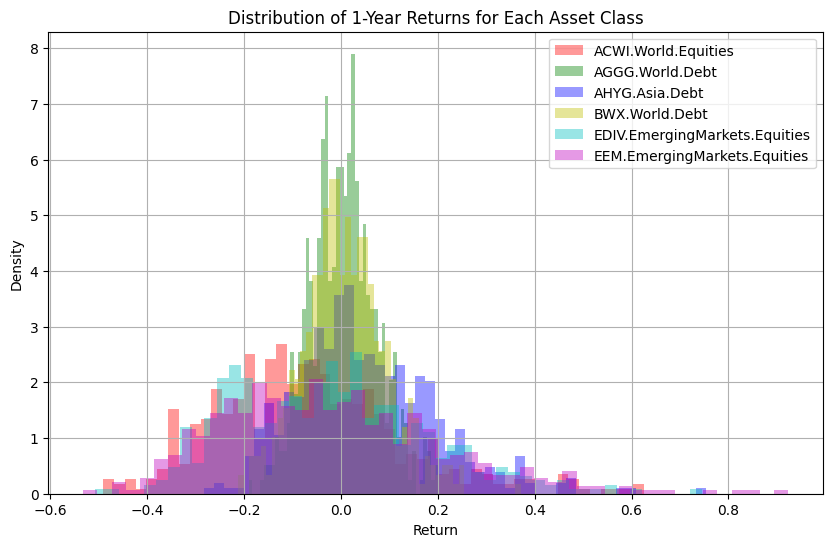

In [125]:
# Simulate daily returns for 1 year using the multivariate normal distribution
simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))

# Calculate cumulative returns for each asset class over 1 year
simulated_cumulative_returns = np.cumprod(1 + simulated_daily_returns, axis=1)[:, -1] - 1

plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b', 'y', 'c', 'm']  # Colors for each asset class (adjust to match the number of assets)

for i, asset_class in enumerate(asset_classes):
    plt.hist(simulated_cumulative_returns[:, i], bins=50, alpha=0.4, color=colors[i], label=asset_class, density=True)

plt.title('Distribution of 1-Year Returns for Each Asset Class')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


Now make same plot but for basic own funds

In [126]:
assets_0 = 1000000
liabilities_0 = assets_0 * 0.6
liability_growth = 0.03

weights = np.array([0.0, 0.8, 0.1, 0.095, 0.0, 0.05]) 

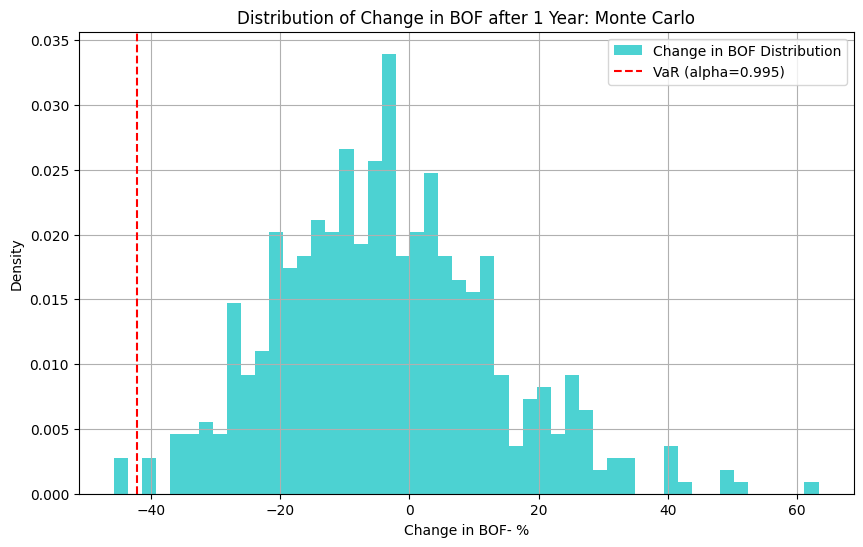

In [127]:
BOF_0 = assets_0 - liabilities_0  

simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))

portfolio_returns = np.dot(simulated_daily_returns, weights) 
simulated_cumulative_returns = np.cumprod(1 + portfolio_returns, axis=1)[:, -1] - 1

assets_t1 = assets_0 * (1 + simulated_cumulative_returns)  # Assets after 1 year
liabilities_t1 = liabilities_0 * (1 + liability_growth)  # Liabilities after 1 year

# Calculate Basic Own Funds (BOF) after 1 year
bof_t1 = assets_t1 - liabilities_t1

bof_change = bof_t1 - BOF_0
bof_change_percentage = (bof_t1 - BOF_0) / BOF_0 * 100 

#scr = np.percentile(bof_change, 100 * (1 - 0.995))
#print("SCR =", scr)

plt.figure(figsize=(10, 6))
plt.hist(bof_change_percentage, bins=50, alpha=0.7, color='c', label='Change in BOF Distribution', density=True)
plt.axvline(np.percentile(bof_change_percentage, 0.5), color='r', linestyle='--', label='VaR (alpha=0.995)')
plt.title('Distribution of Change in BOF after 1 Year: Monte Carlo')
plt.xlabel('Change in BOF- %')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()



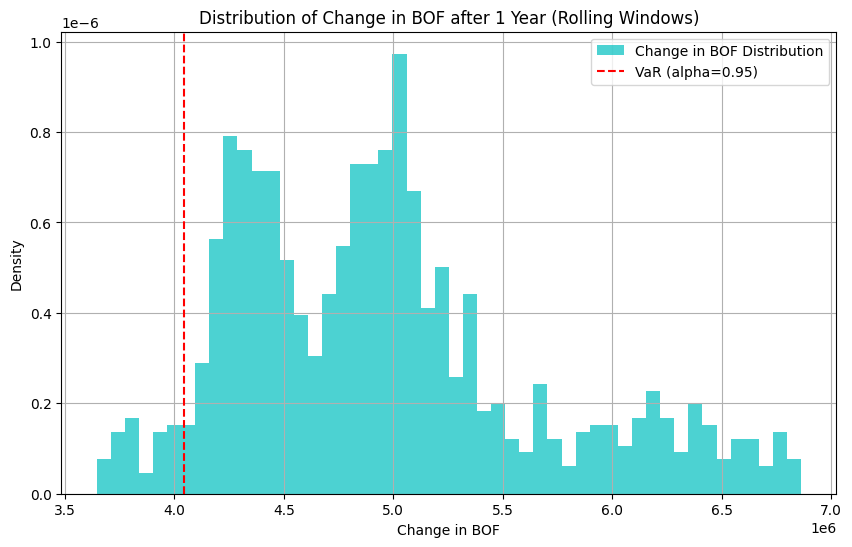

In [128]:
# Step 1: Calculate rolling 1-year (252 trading days) returns
rolling_returns = returns_df.rolling(window=252).apply(lambda x: np.prod(1 + x) - 1, raw=False).dropna()

# Step 2: Calculate assets and liabilities after 1 year for each rolling window
assets_t1 = assets_0 * (1 + rolling_returns)
liabilities_t1 = liabilities_0 * (1 + liability_growth)

# Step 3: Calculate BOF after 1 year for each period
bof_t1 = assets_t1.sum(axis=1) - liabilities_t1  # liabilities_t1 is a scalar, so no axis needed

# Step 4: Calculate the change in BOF from the initial value
bof_change = bof_t1 - (assets_0 - liabilities_0)

# Plot the distribution of BOF changes
plt.figure(figsize=(10, 6))
plt.hist(bof_change, bins=50, alpha=0.7, color='c', label='Change in BOF Distribution', density=True)
plt.axvline(np.percentile(bof_change, 5), color='r', linestyle='--', label='VaR (alpha=0.95)')
plt.title('Distribution of Change in BOF after 1 Year (Rolling Windows)')
plt.xlabel('Change in BOF')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()